In [2]:
# Random Forest Classification

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils

In [3]:
# Importing the dataset
dataset = pd.read_csv('final file hopefully no errors.csv')

In [4]:
#for fib2.cvs only

dataset.loc[dataset['Gen'] == 'ssRNA(+)', 'Gen'] = 1
dataset.loc[dataset['Gen'] == 'ssRNA(-)', 'Gen'] = 0

In [23]:
p = dataset.loc[dataset['Gen'] == 1].reset_index()
n = dataset.loc[dataset['Gen'] == 0].reset_index()

In [35]:
pn = pd.concat([ps,ns]).reset_index(drop = True)

In [8]:
res = pd.read_csv('res 340.csv')

In [25]:
r = res[['ATC', 'ATCA', 'ATCT', 'TGGT']].copy()

In [60]:
pnr = pd.concat([pn, r], axis = 1)

In [61]:
pnr = pnr.drop(index = pnr.loc[pnr['MolTyp'] == 'DNA'].index)

In [62]:
pnr = pnr.drop(columns=['index', 'Id', 'MolTyp', 'Topol', 'Des'])

In [63]:
pnr = pnr.rename(columns={'ATC' : 'E1', 'ATCA' : 'E2', 'ATCT' : 'E3', 'TGGT' : 'E4'})

sample

In [73]:
ps = pnr.loc[pnr['Gen'] == 1].sample(200)
ns = pnr.loc[pnr['Gen'] == 0].sample(200)

pnrs = pd.concat([ps,ns])

make features

In [76]:
#feature 1: length
pnrs['F1'] = [len(i) for i in pnrs['Seq'].to_list()]

In [66]:
#orf_translator function to find orfs and translate them

a = Seq(pnrs.loc[0,'Seq'], IUPAC.unambiguous_dna)
rec = SeqRecord(a)
table = 11
min_pro_len = 20

def orf_translator(record, table, min_pro_len):
    s1 = []
    s2 = []
    for strand, nuc in [(+1, record.seq), (-1, record.seq.reverse_complement())]:
        for frame in range(3):
            length = 3 * ((len(record)-frame) // 3) #Multiple of three
            for pro in nuc[frame:frame+length].translate(table).split("*"):
                if len(pro) >= min_pro_len:
                    if strand == 1:
                        s1.append(pro)
                    else:
                        s2.append(pro)
    return s1,s2

#orf_translator(rec, 11, 20)

In [77]:
#feature 2: number of orfs on strand 1
#feature 3: number of orfs in strand 2
#feature 4: mean protein length on strand 1
#feature 5: mean protein length on strand 2
#feature 6: GC content
#feature 7: no idea what this feature is

f2, f3, f4, f5, f6, f7 = [],[],[],[],[],[]

for i in pnrs['Seq'].to_list():
    a = SeqRecord(Seq(i))
    (s1, s2) = orf_translator(a, 11, 15)
    f2.append(len(s1))
    f3.append(len(s2))
    
pnrs['F2'] = f2
pnrs['F3'] = f3

In [79]:
#Splitting features and labels
X = pnrs.iloc[:, 3:].values.astype(float)
y = pnrs.iloc[:, 1].values.astype(float)

In [84]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [85]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [86]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [87]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [88]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


In [89]:
cm

array([[42,  3],
       [ 2, 53]], dtype=int64)

In [387]:
#did not fix visualization errors. Too difficult for now.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


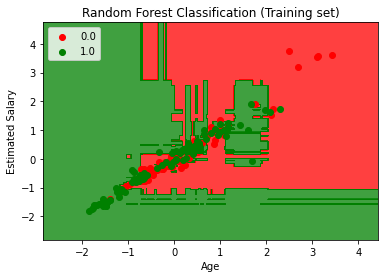

In [370]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()